# The Nature of Time for `AgentType`s

This notebook provides documentation and a tutorial on how time is structured for instances of `AgentType`, its framework for representing microeconomic dynamic models. It includes a number of examples of solving and simulating models with different timing structures using HARK, including standard infinite horizon, lifecycle problems, and cyclical models.

In [1]:
# Import some basic tools
import numpy as np
from HARK.ConsumptionSaving.ConsIndShockModel import (
    PerfForesightConsumerType,
    IndShockConsumerType,
)
import matplotlib.pyplot as plt
from HARK.utilities import plot_funcs

mystr = lambda number: f"{number:.4f}"

## It's about time: `cycles` and `T_cycle`

HARK's microeconomic framework is designed to accomodate different timing structures with minimal user effort. The key attributes of an `AgentType` instance that specify its time structure are `T_cycle` and `cycles`.

An `AgentType`'s "cycle" is a sequence of periods that the agent will experience in order (conditional on survival), each characterized by some data/parameters. In a **standard lifecycle problem**, the "cycle" is a lifecycle, providing a sequence of periods that the individual will live out exactly as they age, one by one. In an **infinite horizon problem**, the "cycle" is truly cyclical, as the sequence of periods recurs back on itself, starting over when it reaches the end. In a **standard infinite horizon problem**, there is only one period in the "cycle", which happens over and over again.

The `T_cycle` attribute is a whole number that indicates **how many periods are in the cycle**. In a lifecycle model, this will be either the total number of periods in the lifecycle (commonly $T$) or the number of non-terminal periods ($T-1$); this depends on the `pseudo_terminal` attribute, which will be discussed below. In a standard infinite horizon problem, `T_cycle=1`, indicating that one period recurs in a loop. Critically, all time-varying solver inputs (those named in `time_vary`) must be in a list with exactly `T_cycle` elements.

The `cycles` attribute is a whole number that tells HARK **how many times the cycle occurs**, with a special value of `cycles=0` indicating that the cycle occurs infinitely many times. (We use `0` to indicate infinite horizon because it is easier than typing `np.inf`.) In a standard lifecycle problem, `cycles=1`: the lifecycle of periods happens once.

Most "real" applications will be either standard lifecycle problems or standard infinite horizon problems, but HARK offers flexibility to represent less common cases as well. *Most* `AgentType` subclasses are designed to be used with any timing structure, but there are some exceptions. For example, the `RepAgentConsumerType` is for an economy with a single representative agent (despite being in **HA**RK), so its solution only makes sense in an infinite horizon setting. Likewise, the `TractableBufferStockConsumerType` is a specialized model for teaching purposes that is *only* infinite horizon. In the other direction, there are `AgentType` subclasses that would *usually* only be interesting in a lifecycle, because the key model elements are so closely tied to (human) age.

## The perfect foresight model with age-dependent parameters

To proceed with our first examples, recall the deterministic, life-cycle version of the perfect foresight model such that it accomodates age-dependent survival probability and/or income growth. $\newcommand{\LivPrb}{\mathsf{S}}$

\begin{align*}
V_t(M_t,Y_t) &= \max_{C_t}~U(C_t) + \beta \LivPrb_t V_{t+1}(M_{t+1},Y_{t+1}), \\
& s.t.  \\
%A_t &= M_t - C_t, \\
M_{t+1} &= R_{t+1} (M_{t}-C_{t}) + Y_{t+1}, \\
Y_{t+1} &= \Gamma_{t+1} Y_t, \\
\end{align*}

Where $Y_t$ is an age-dependent income, $\LivPrb_t$ is a survival  probability and $\Gamma_{t+1}$ is an income growth rate. Also $\LivPrb_{T} =0$, meaning that the agent cannot survive past the terminal age.

### What parameters can depend on age?

In each HARK model, some parameters are **time-invariant**, taking on the same values in each period, while others are **time-varying**, potentially taking on different values in each period of the cycle. To see which is which, you can look at the `time_inv` and `time_vary` attributes of an `AgentType` instance.

In [2]:
# Make a default perfect foresight consumer
QuickPFexample = PerfForesightConsumerType()
print("Time-invariant model inputs:")
print(QuickPFexample.time_inv)
print("Time-varying model inputs:")
print(QuickPFexample.time_vary)
print("Default model has cycles=" + str(QuickPFexample.cycles))
print("Default model has T_cycle=" + str(QuickPFexample.T_cycle))

Time-invariant model inputs:
['CRRA', 'DiscFac', 'MaxKinks', 'BoroCnstArt']
Time-varying model inputs:
['LivPrb', 'PermGroFac', 'Rfree']
Default model has cycles=1
Default model has T_cycle=1


This says that the **coefficient of relative risk aversion, discount factor, artificial borrowing constraint, and maximum number of consumption-function kinks** are constant with respect to time or age. Moreover, **the survival probabilities, income growth rates, and risk-free interest factor** can vary with time or age.

To see what this means with the default parameters for the perfect foresight model, let's look at each of those attributes. Those named in `time_inv` will (probably) *not* be lists, while those named in `time_vary` *must* be lists.

In [3]:
for var in QuickPFexample.time_inv:
    print(var + " = " + str(getattr(QuickPFexample, var)))
for var in QuickPFexample.time_vary:
    print(var + " = " + str(getattr(QuickPFexample, var)))

CRRA = 2.0
DiscFac = 0.96
MaxKinks = 400
BoroCnstArt = None
LivPrb = [0.98]
PermGroFac = [1.01]
Rfree = [1.03]


To specify a lifecycle model, the user should provide the lists of length `T_cycle` for survival probabilities (`LivPrb`), income growth factors (`PermGroFac`), and the interest factor (`Rfree`). They should also provide single values for `CRRA`, `DiscFac`, `MaxKinks` (irrelevant in finite horizon), and `BoroCnstArt`. Finally, `cycles` must be set to `1` to indicate that it is a lifecycle problem, and the `T_cycle` attribute should be set to the number of non-terminal periods. In most (but not all) HARK models, a terminal period is added automatically.

To specify a standard infinite horizon model, the user should set `T_cycle` to `1` and provide **singleton lists** for `LivPrb`, `PermGroFac`, and `Rfree`; the `cycles` attribute should be set to `0` to indicate that it is infinite horizon.

### Finite horizon, life-cycle example model

First, consider a finite-horizon life-cycle example. We create an agent-type object with ten non-terminal periods (`T_cycle=10`), decreasing survival probability, and inverse u-shape income dynamics up to period 6 (the consumer retired). This is acheived by the list of parameters in the code block below.

In [4]:
LifeCycle_dictionary = {
    "CRRA": 2.0,
    "DiscFac": 0.96,
    "BoroCnstArt": None,
    "Rfree": 10 * [1.03],  # ten copies of the same number
    "LivPrb": [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.90],
    "PermGroFac": [1.01, 1.01, 1.01, 1.02, 1.00, 0.99, 0.5, 1.0, 1.0, 1.0],
    "T_cycle": 10,  # Our time varying parameters are a list with 10 elements
    "cycles": 1,  # Repeats once
}

# Pass the dictionary to the class to instantiate it
LC_agent = PerfForesightConsumerType(**LifeCycle_dictionary)

To solve the model, we use the `solve` method method to find the optimal consumption function in each period. In case of $\Gamma_t \neq 1.0$, these functions are defined on the **normalized** space of the cash-on-hand argument-- they use market resources and consumption *divided by* permanent income $Y_t$, because the problem is homothetic w.r.t $Y_t$.

In [5]:
# Solve the lifecycle agent's problem
LC_agent.solve()
print("First element of solution is", LC_agent.solution[0])
print("Solution has", len(LC_agent.solution), "elements.")

First element of solution is <HARK.ConsumptionSaving.ConsIndShockModel.ConsumerSolution object at 0x7ff94566dd80>
Solution has 11 elements.


This was supposed to be a *ten* period lifecycle model-- why does our consumer type have *eleven* elements in its `solution`?  It would be more precise to say that this specification has ten *non-terminal* periods. The solution to the 11th and final period in the model would be the same for every set of parameters: consume $c_T = m_T$, because there is no future.  In a lifecycle model, the terminal period is assumed to exist; the `LivPrb` parameter does not need to end with a `0.0` in order to guarantee that survivors die.

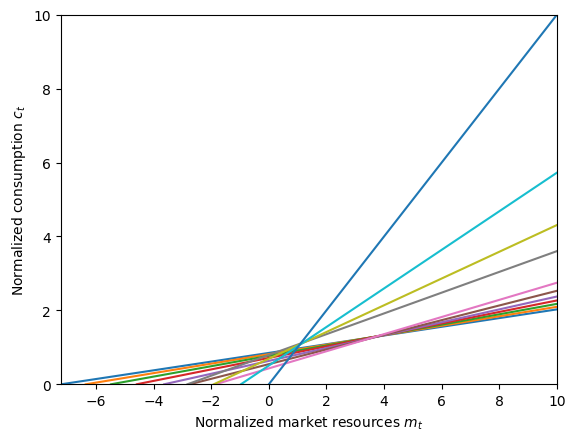

In [6]:
# Plot each of the consumption functions
LC_agent.unpack("cFunc")
min_v = min(LC_agent.solution[t].mNrmMin for t in range(11))
max_v = 10.0
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 10.0)
plot_funcs(LC_agent.cFunc, min_v, max_v)

Because we set `BoroCnstArt` to `None`, a consumer with no income risk can fully borrow against all future income they will receive. Hence the solution for $t=T$ is $c_T = m_T$ (the slope 1 line), and in each prior period the agent can borrow against more future income and has a lower marginal propensity to consume.

### Standard infinite horizon example model

The other "standard" case in HARK besides a lifecycle model is a standard infinite horizon problem, with one period repeated indefinitely. To specify such a model, we can use the default parameters for `PerfForesightConsumerType` (shown above) but specify `cycles=0`.

When the model is solved, HARK will automatically solve the same one-period problem repeatedly, feeding each iteration back to itself. After each solution iteration, it compares the solutions to successive passes and generates a measure of their "distance" apart-- how much the solution has changed on the latest iteration. When this difference is less than the agent's `tolerance` parameter (which has a default value of 0.000001), the process terminates.

In [7]:
# Make and solve a perfect foresight agent with default parameters and infinite horizon
IH_agent = PerfForesightConsumerType(cycles=0)
IH_agent.solve()

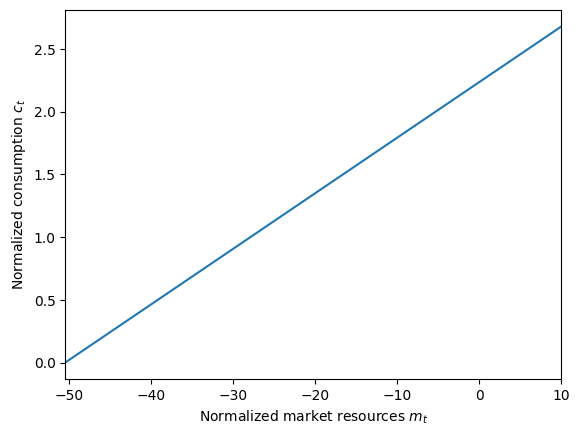

In [8]:
# Plot the infinite horizon perfect foresight solution
IH_agent.unpack("cFunc")
min_v = IH_agent.solution[0].mNrmMin
max_v = 10.0
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(IH_agent.cFunc, min_v, max_v)

With no borrowing constraint, the infinite horizon consumer can borrow more and more against their future earnings as their time horizon becomes longer and longer. The backward iteration process only stops when the finite approximation to their infinite horizon human wealth (the PDV of future labor income) becomes sufficiently accurate.

The infinite horizon solution looks a lot different if the agent *can't* borrow against future income. Let's do the same exercise, but with an artifical borrowing constraint of `BoroCnstNat=0.0`, indicating that the agent must end each period with assets $a_t \geq 0$.

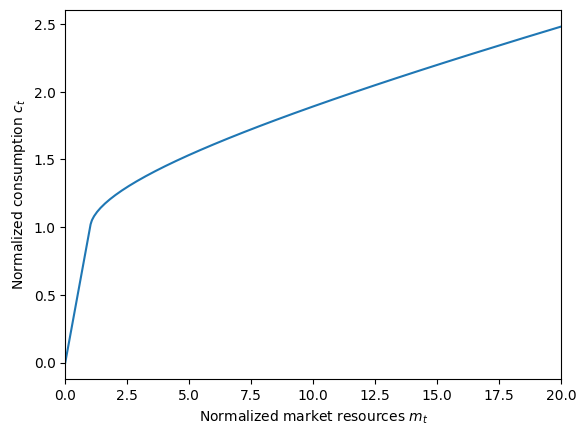

In [9]:
# Make and solve a constrained perfect foresight agent with an infinite horizon
IH_cnst_agent = PerfForesightConsumerType(cycles=0, BoroCnstArt=0.0)
IH_cnst_agent.solve()

# Plot the constrained consumption function
IH_cnst_agent.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(IH_cnst_agent.cFunc, 0.0, 20.0)

It's probably hard to tell, but that consumption function is actually made up of linear segments, even though it *looks* smooth. And it's not an *approximate* solution like most interpolants, but instead an *exact* solution (at least to machine precision). With a constrained perfect foresight solution, the solver adds one additional kink point on each iteration. This process *would* continue indefinitely, but the `MaxKinks` attribute indicates the largest number of kink points to include. Beyond that, the highest kink point is "thrown out" and HARK finds that the solutions to successive iterations are identical, terminating the solver loop.

The constrained perfect foresight solution is *always* less than the unconstrained solution, approaching it asymptotically. Let's plot both of them on the same figure, with a much larger scale.

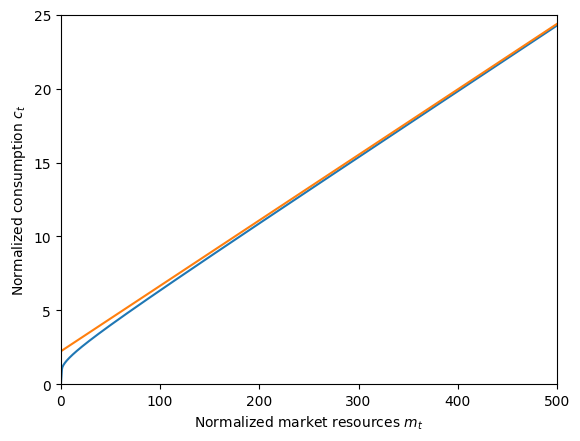

In [10]:
# Plot the constrained and unconstrained consumption functions
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 25.0)
plot_funcs(IH_cnst_agent.cFunc + IH_agent.cFunc, 0.0, 500.0)

### Infinite horizon cyclical example model

Next, consider an infinite horizon problem in the following setting: the consumer lives with certainty but her income varies cyclically. During each cycle she experiences two periods of income increase and two of income decrease.

We assume that within each cycle, the income growth factors are `[1.05, 1.1, 0.95, 0.92]`. In each period, we also assume that survival probability is 1. The rest of the parameters use their default values.

Below, we create a HARK `AgentType` object with this income process. Notice that the cycles parameter is set to 0 in this case (infinite horizon), while `T_cycle` is 4, because there are four periods in the looping cycle.

In [11]:
Cyc_dictionary = {
    "Rfree": 4 * [1.03],  # 4 copies of the same value
    "PermGroFac": [1.05, 1.1, 0.95, 0.92],  # 4 different income growth rates
    "LivPrb": 4 * [1.0],  # no mortality
    "cycles": 0,  # 0 for infinite horizon
    "T_cycle": 4,  # 4 periods in the looping cycle
}

# Make and solve the "cyclical" agent
Cyc_agent = PerfForesightConsumerType(**Cyc_dictionary)
Cyc_agent.solve()

When we plot this agent's consumption functions, there will be **four** functions, one for each period of the cycle. From the perspective of each period, there are an infinite number of future periods, but they will arrive **in the short run** in a different order.

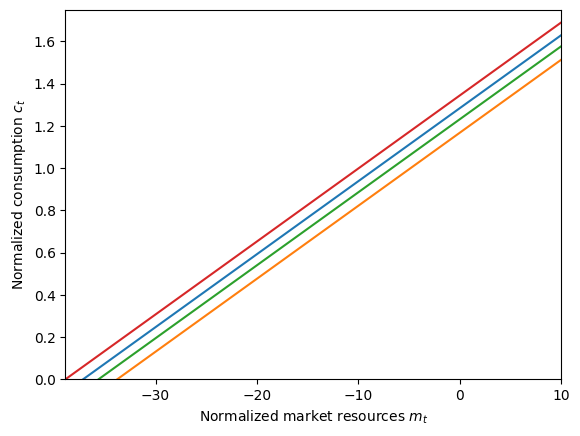

In [12]:
# Plot the cyclical consumption functions
Cyc_agent.unpack("cFunc")
min_v = np.min([Cyc_agent.solution[t].mNrmMin for t in range(4)])
max_v = 10.0
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 1.75)
plot_funcs(Cyc_agent.cFunc, min_v, max_v)

## Consumption-saving models with a realistic income process

Moving on from the perfect foresight model, let's consider the workhorse consumption-saving model under income risk. In this model, the agent chooses how much to consume vs save (in a risk-free asset) each period, but their labor income is subject to both **permanent** and **transitory** shocks. The model can be written in Bellman form as:

\begin{align*}
v_t(m_t) &= \max_{c_t} U(c_t) + \beta \LivPrb_t E \left[G_{t+1}^{1-\rho} v_{t+1}(m_{t+1}) \right] ~~ \text{s.t.} \\
a_t &= m_t - c_t, \\
a_t &\geq \underline{a}, \\
k_{t+1} &= a_t, \\
b_{t+1} &= (R_{t+1} / G_{t+1}) k_{t+1}, \\
m_{t+1} &= b_{t+1} + \theta_{t+1}, \\
G_{t+1} &= \Gamma_{t+1} \psi_{t+1}, \\
(\psi_{t+1}, \theta_{t+1}) &\sim F_{t+1}, \\
U(c) &= \frac{c^{1-\rho}}{1-\rho}.
\end{align*}

Like the perfect foresight agent above, these agents might be subject to a borrowing constraint $\underline{a}$ on their end-of-period assets. Their retained assets yield interest at factor $R_t$, while their permanent and transitory income shocks are drawn from $F_t$. Because of the permanent income normalization, permanent income shocks $\psi$ should be mean 1, so that the permanent income growth factor $\Gamma_t$ represents the average or expected growth factor.

Just like with the perfect foresight model, let's see which parameters are time-varying and which are time-invariant for the `IndShockConsumerType`, the `AgentType` subclass that represents this model.

In [13]:
# Make a default agent and look at its attribute names
QuickIndShkExample = IndShockConsumerType()
print("Time-invariant model inputs:")
print(QuickIndShkExample.time_inv)
print("Time-varying model inputs:")
print(QuickIndShkExample.time_vary)

Time-invariant model inputs:
['CRRA', 'DiscFac', 'BoroCnstArt', 'vFuncBool', 'CubicBool', 'aXtraGrid']
Time-varying model inputs:
['LivPrb', 'PermGroFac', 'Rfree', 'IncShkDstn', 'PermShkDstn', 'TranShkDstn']


The model with income risk adds several new model inputs. For time-invariant inputs, these include options to construct the value function or use cubic spline interpolation, a grid of "assets above minimum". For time-varying inputs, the new items are the distributions of permanent and transitory income shocks and and their joint representation `IncShkDstn`.

It isn't discussed in this notebook, but `aXtraGrid` and the income distribution objects are **constructed** model inputs. Rather than manually specifying the assets grid or income distribution, the user provides parameters that *describe* them, which are used by a constructor function to build the model inputs.

### Finite horizon, life-cycle problem

As a first example, let's make consumers of this class with a *lifecycle*-- parameter values that differ by age, with a finite end point beyond which the individual cannot surive. This can be done by specifying the time-varying attributes as lists specifying the sequence of periods these agents will experience, from beginning to end.

In the cell below, we define a parameter dictionary for a rather short ten period lifecycle, with arbitrarily chosen parameters.  For a more realistically calibrated (and much longer) lifecycle model, see the [SolvingMicroDSOPs REMARK](https://github.com/econ-ark/REMARK/blob/master/REMARKs/SolvingMicroDSOPs.md).

Note that the dictionary only specifies parameters that deviate from their default values, or that we want to draw attention to.

In [14]:
LifecycleDict = {  # Click arrow to expand this fairly large parameter dictionary
    # Parameters shared with the perfect foresight model
    "Rfree": 10 * [1.03],
    "LivPrb": [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9],
    "PermGroFac": [1.01, 1.01, 1.01, 1.02, 1.02, 1.02, 0.7, 1.0, 1.0, 1.0],
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd": [0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0, 0, 0],
    "TranShkStd": [0.3, 0.2, 0.1, 0.3, 0.2, 0.1, 0.3, 0, 0, 0],
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "UnempPrbRet": 0.0005,  # Probability of "unemployment" while retired
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "T_retire": 7,  # Period of retirement (7 --> retirement begins at t=7)
    # Don't forget to set these for a lifecycle model!
    "cycles": 1,  # life-cycle model: sequence of periods happens *once*
    "T_cycle": 10,  # there are 10 non-terminal periods
}

In this case, we have specified a ten period model in which retirement happens in period $t=7$.  Agents in this model are more likely to die as they age, and their permanent income drops by 30\% at retirement.  Let's make and solve this lifecycle example, then plot the consumption functions in each period of the model:

In [15]:
LifecycleExample = IndShockConsumerType(**LifecycleDict)
LifecycleExample.solve()

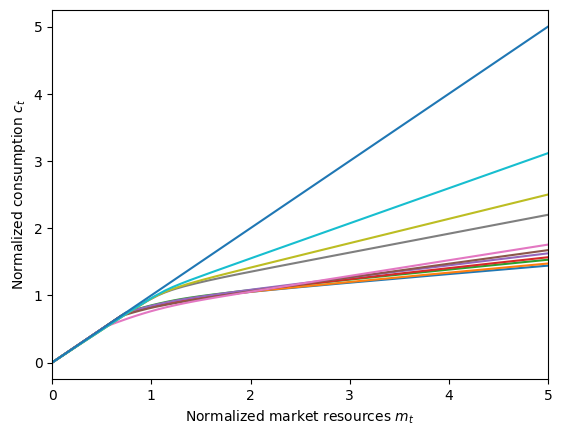

In [16]:
LifecycleExample.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(LifecycleExample.cFunc, 0.0, 5.0)

The lower seven consumption functions correspond to the "working" portion of this simplified life-cycle, and the four highest consumption functions correspond to the "retired" portion of the model, from $t=7$ to $t=10$. After retirement, the agent will consume more *relative to their permanent income* for three reasons:

1. Their permanent income recently decreased considerably (falling by 30%)
2. They face very little income risk and can make plans (essentially) without uncertainty
3. They face imminent death after $t=10$ and know that they "can't take it with them"

### Standard infinite horizon problem

Just like with the perfect foresight model, it is very simple to make a standard infinite horizon consumer with realistic income risk: just set `cycles=0` with the default parameters for `IndShockConsumerType` and solve the model. Let's do that and plot the consumption function.

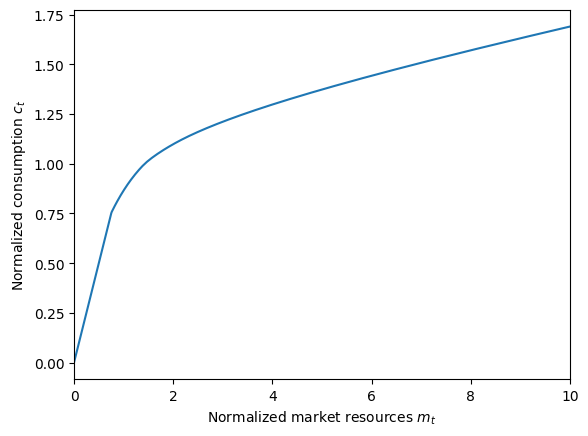

In [17]:
# Make and solve an infinite horizon consumer with income risk
InfiniteAgent = IndShockConsumerType(cycles=0)
InfiniteAgent.solve()

# Plot the consumption function
InfiniteAgent.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(InfiniteAgent.cFunc, 0.0, 10.0)

The kink in the consumption function around $m_t = 0.75$ represents the point at which the artificial borrowing constraint begins to bind. Below this level of market resources, the consumer would *like* to consume more (and borrow against future earnings), but isn't permitted to. The best they can do is to consume all of their resources.

### Infinite horizon, cyclical problem

Finally, we model consumers who face an infinite horizon, but who do *not* face the same problem in every period.  Consider someone who works as a ski instructor: they make most of their income for the year in the winter, and make very little money in the other three seasons.

We can represent this type of individual as a four period, infinite horizon model in which expected "permanent" income growth varies greatly across seasons. The dictionary below specifies only the parameters that deviate from the defaults for `IndShockConsumerType`.

In [18]:
CyclicalDict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 4 * [1.03],  # Interest factor on assets
    "LivPrb": 4 * [0.98],  # Survival probability
    "PermGroFac": [1.082251, 2.8, 0.3, 1.1],
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd": 4 * [0.1],
    "TranShkStd": 4 * [0.2],
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    # Don't forget to specify how time works!
    "cycles": 0,  # Infinite horizon, repeating cycle
    "T_cycle": 4,  # Number of periods in the cycle for this agent type
}

This consumer type's parameter dictionary is nearly identical to the original infinite horizon type we made, except that each of the time-varying parameters now have *four* values, rather than just one.  Most of these have the same value in each period *except* for `PermGroFac`, which varies greatly over the four seasons.  Note that the product of the four "permanent" income growth factors is almost exactly 1.0-- this type's income does not grow on average in the long run!

Let's make and solve this consumer type, then plot his quarterly consumption functions:

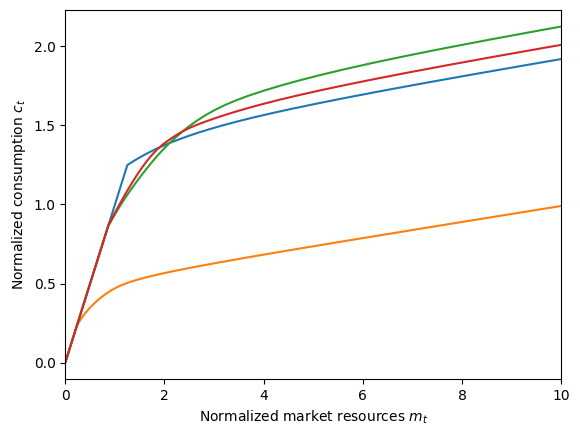

In [19]:
CyclicalExample = IndShockConsumerType(**CyclicalDict)
CyclicalExample.cycles = 0  # Make this consumer type have an infinite horizon
CyclicalExample.solve()

CyclicalExample.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(CyclicalExample.cFunc, 0.0, 10.0)

The very low orange consumption function corresponds to the quarter in which the ski instructors make most of their income.  They know that they are about to experience a 70% drop in "permanent" income, so they do not consume much *relative to their income this quarter*.  In the other three quarters, *normalized* consumption is much higher, as current "permanent" income is low relative to future expectations.  In *level*, the consumption chosen in each quarter is much more similar.

Note that a similar result could be reached by specifying the income cyclicality as being in *transitory* income, so that mean `TranShk` is not necessarily 1 each period. This would require using a custom constructor for `IncShkDstn`, but HARK can handle it just fine.

## Non-standard time structures

Most of the time, you will want `cycles=0` and `T_cycle=1` **or** `cycles=1` and `T_cycle=T-1`. In the sections above, we showed how you can also have infinite horizon problems that aren't just the same period repeating infinitely (`cycles=0` and `T_cycle > 1`). There are other ways timing can be set up in HARK, which we discuss in this section.

### Finite horizon approximation to infinite horizon problem

The "infinite horizon" solution is found by repeatedly solving the cycle of periods until successive iterations are sufficiently close together, indicating convergence. Even if you are working with an infinite horizon problem, sometimes you are interested in its behavior as it iterates backward. In this case, you can start with a standard infinite horizon problem, but set `cycles` to be a finite number. The "one period cycle" will be solved `cycles` times, and all of the intermediate solutions will be returned in the agent's `solution`. This can be useful when first programming a solver in HARK: you'll want to see if it can solve 1, 2, 5, 10, and 20 periods backward before trying to solve the infinite horizon problem!

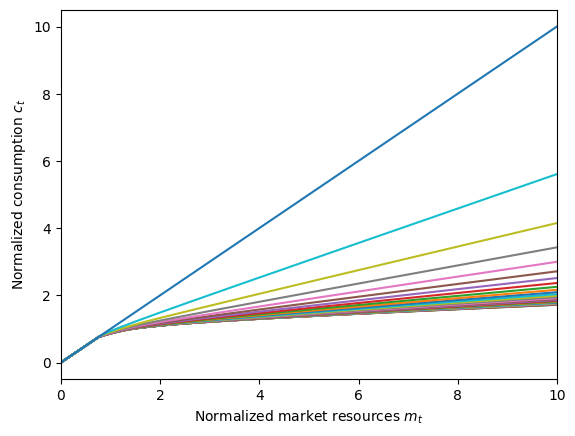

In [20]:
# Make a consumer with income risk under default parameters, but only solve 30 non-terminal periods
ShortHorizonAgent = IndShockConsumerType(cycles=30)
ShortHorizonAgent.solve()

# Plot the 31 consumption functions
ShortHorizonAgent.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(ShortHorizonAgent.cFunc, 0.0, 10.0)

Note that the default parameters for `IndShockConsumerType` have `T_cycle=1`, so setting `cycles=30` means that the "one period cycle" will be played out 30 times, followed by the terminal period ($c_T = m_T$). After only 30 non-terminal periods, the consumption function is already getting pretty close to the infinite horizon solution!

### Strange aeons

To see the general principle of how HARK timing works, consider a very unusual case: a consumer who lives out **a sequence of ten periods five times**. We will use a parameter dictionary that's similar to the one for the lifecycle example, but not quite the same.

In [21]:
VeryStrangeDict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 10 * [1.03],
    "LivPrb": [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9],
    "PermGroFac": [1.01, 1.01, 1.01, 1.02, 1.02, 1.02, 1.03, 1.03, 1.04, 1.04],
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd": [0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2],
    "TranShkStd": [0.3, 0.2, 0.1, 0.3, 0.2, 0.1, 0.3, 0.2, 0.1, 0.5],
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    # Don't forget to set these for a lifecycle model!
    "T_cycle": 10,  # there are 10 non-terminal periods *in the cycle*
    "cycles": 5,  # and in strange aeons, we run the cycle 5 times
}

# Make and solve this very strange agent
VeryStrangeAgent = IndShockConsumerType(**VeryStrangeDict)
VeryStrangeAgent.solve()
print("There are " + str(len(VeryStrangeAgent.solution)) + " elements in the solution.")

There are 51 elements in the solution.


Why are there 51 elements in the solution? Because there are **ten** periods in the cycle, the cycle happens **five** times, and there is **one** terminal period at the very end: $5 \times 10 + 1 = 51$. When `cycles > 0`, the number of elements in `solution` is `T_cycle * cycles + not(pseudo_terminal)`; when `cycles = 0`, the number of elements in `solution` is exactly `cycles`. 

In the prior expression, we treated the Boolean variable `pseudo_terminal` as if it were an integer. In Python, when a `bool` is "cast" to an `int`, `False` gets the value `0` and `True` gets the value `1`. For an explanation of `pseudo_terminal`, see below.

For the sake of completeness, let's plot the consumption functions.

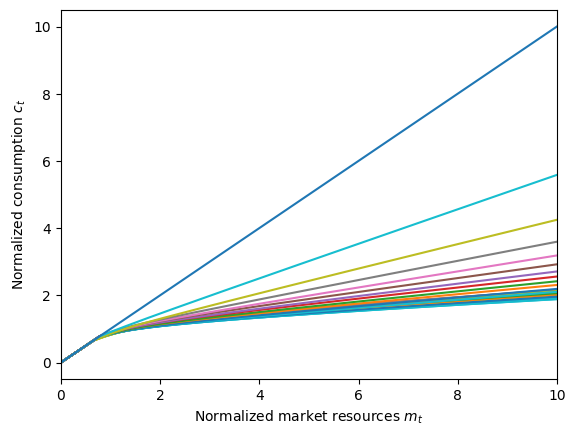

In [22]:
# Plot the 51 consumption functions
VeryStrangeAgent.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(VeryStrangeAgent.cFunc, 0.0, 10.0)

## This could be the end: `pseudo_terminal`

There is one final detail of HARK's microeconomic timing to explain: the `pseudo_terminal` attribute. In most (but not all) HARK solvers, the terminal period is trivial to solve-- it's often something like "consume all resources". Rather than do this task with the ordinary one-period solver function, many HARK models build it in advance (as `solution_terminal`) in just a few lines of code. This period really *is* part of the solution of the model, even if we didn't have to do much work to get it-- an agent really could live to age $T$ and consume everything.

However, for some models, even the terminal period solution is non-trivial, and the ordinary one-period solver must be used. One-period solvers in HARK always need a `solution_next` input, so the `solution_terminal` is constructed as a "dummy" solution that represents "time beyond time". It likely has a zero value function and irrelevant policy functions. It is an object that exists solely so that the one-period solver can use it, even if all of its outputs are immediately thrown out (usually by multiplying by zero survival probability). In this case, `solution_terminal` *isn't* really part of the model solution-- it's just a code object so we can get started.

The `pseudo_terminal` attribute is used to differentiate these cases. When `pseudo_terminal` is `False`, the constructed `solution_terminal` really is the terminal period solution, and it will be included in `solution` when `cycles > 0`. When `pseudo_terminal` is `True`, the `solution_terminal` is a dummy object and will *not* be included in `solution`. This explains the `not(pseudo_terminal)` term in the prior subsection's explanation of the number of elements in `solution`.

Note that in an *infinite horizon* problem, the `pseudo_terminal` attribute is irrelevant in two ways. First, the number of elements in the model's `solution` is always exactly `T_cycle`, so you wouldn't expect the "terminal" period to show up at all. Second, the `solution_terminal` object represents a *starting guess* for the infinite horizon solution, not a "real" terminal period. If the solution method is based on backward iteration (as it is for nearly all HARK models), then it could be *any* solution guess because the one-period solver is a contraction mapping.